In [840]:
%load_ext autoreload
%autoreload 2
import matplotlib.pyplot as plt
from tqdm import tqdm
import numpy as np
from utils import *
from wishart import *
from sklearn.cluster import DBSCAN
import torch
import torch.nn as nn
# import import_ipynb
# from NN import binaryClassification


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [841]:
patterns, patterns_depth = generate_patterns(betta=None, L=4, K_max=5)
depth_max = patterns_depth.max()

In [854]:
y = np.loadtxt('lorenz.txt')
train_size=10000; test_size=180; h_max = 25;
k=11; h=0.2;
y_train = y[-(train_size+test_size+h_max+depth_max-1):-(test_size+h_max+depth_max-1)]
y_test = y[-(test_size+h_max+depth_max-2):]

In [855]:
patterns_motifs = []
for i in tqdm(range(len(patterns))):
    pattern = patterns[i]
    N, z, neighbours, p, depth, ind= transform(y_train, k, pattern)
    labels = wishart(N, z, p, neighbours, h, ind)
    motifs = get_cendtroids(z, labels)
    patterns_motifs.append(motifs)

100%|██████████| 125/125 [00:33<00:00,  3.76it/s]


In [687]:
np.save('patterns_motifs.npy', patterns_motifs)
# patterns_motifs = np.load('patterns_motifs.npy', allow_pickle=True)

In [856]:
X, y = daemon_predict(0.1, h_max, test_size, depth_max, 
                      patterns, patterns_depth, y_test, patterns_motifs
                     )

np.save('X.npy', X)
np.save('y.npy', y)

100%|██████████| 25/25 [05:22<00:00, 12.90s/it]


In [858]:
max_predict_length = np.max(list(map(lambda x: len(x), X)))
max_predict_length

662

In [874]:
idx = np.where(np.array(y)==1)[0]
# print(idx)
k=8
possible_predicts = X[idx[k]]
el = np.concatenate((np.zeros(max_predict_length - len(possible_predicts)), possible_predicts))
# el = torch.FloatTensor(scaler.fit_transform(el[:, None]).T)
el = torch.FloatTensor(el)
model.eval()
with torch.no_grad():
    non_predictable = bool(int(torch.round(torch.sigmoid(model(el))).numpy().squeeze()))
    
print(non_predictable)

True


In [877]:
from classification_net import binaryClassification
model = binaryClassification(max_predict_length)
model.load_state_dict(torch.load('np_points_classifier'))

<All keys matched successfully>

In [879]:
with_np_points = predict_with_np(max_predict_length, model, h_max, test_size, 
                depth_max, patterns, patterns_depth, y_test, patterns_motifs)

100%|██████████| 25/25 [05:49<00:00, 13.99s/it]


In [881]:
forced = forced_predict(h_max, test_size, depth_max, patterns, patterns_depth, y_test, patterns_motifs)

100%|██████████| 25/25 [09:09<00:00, 21.97s/it]


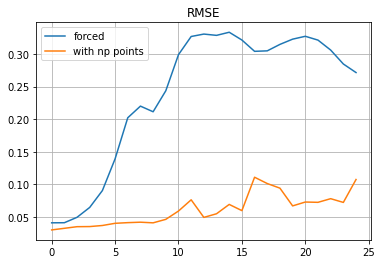

In [918]:
plt.title('RMSE')
plt.plot(forced['rmse'],label='forced')
plt.plot(with_np_points['rmse'], label='with np points');
plt.grid()
plt.legend();

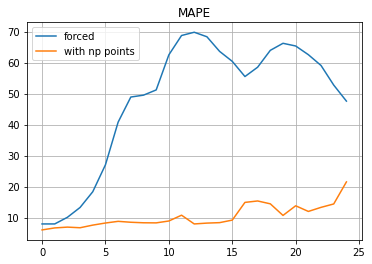

In [913]:
plt.title('MAPE')
plt.plot(forced['mape'],label='forced')
plt.plot(with_np_points['mape'], label='with np points');
plt.grid()
plt.legend();

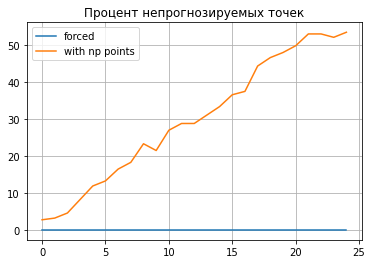

In [916]:
plt.title('Процент непрогнозируемых точек')


plt.plot(forced['non_pred'], label='forced')
plt.plot(100*with_np_points['non_pred']/len(y_test), label='with np points')
plt.grid()
plt.legend();

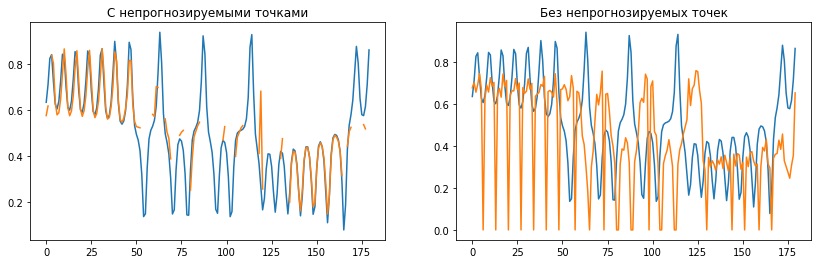

In [909]:
k=10
plt.figure(figsize=(14,4))
plt.subplot(121)
plt.plot(y_test[h_max+depth_max-2:])
plt.plot(with_np_points['h_step'][k])
plt.title('C непрогнозируемыми точками')
plt.subplot(122)
plt.plot(y_test[h_max+depth_max-2:])
plt.plot(forced['h_step'][k])
plt.title('Без непрогнозируемых точек');

##### Расчет показателя Ляпунова

In [920]:
import nolds

In [936]:
# nolds.lyap_r(y_train)

In [935]:
# nolds.lyap_e(y_train, emb_dim=4)

array([ 0.09743023, -0.00460925, -0.3200099 , -0.9751246 ], dtype=float32)